In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
# reinforcement learning
import gym
from gym import error, spaces, utils
from gym.utils import seeding

from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, BatchNormalization, Conv1D, InputLayer, Dropout, regularizers, Conv2D, Reshape
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu

Using TensorFlow backend.


In [9]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

# from src.callbacks.rl_callbacks import ReduceLROnPlateau, TrainIntervalLoggerTQDMNotebook

In [10]:
window_length = 50

# Environment

Day trading over 256 days. We scale and augment the training data.

You can see the base environment class [here](https://github.com/openai/gym/blob/master/gym/core.py#L13) and openai's nice docs [here](https://gym.openai.com/docs)


In [11]:
from src.environments.portfolio import PortfolioEnv

In [13]:
df_train = pd.read_hdf('./data/poliniex_30m.hf',key='train')
env = PortfolioEnv(
    df=df_train,
    steps=30, 
    scale=True, 
    augment=0.0000, # let just overfit first,
    trading_cost=0, # let just overfit first,
    window_length = window_length,
    
)
env.seed = 0   

df_test = pd.read_hdf('./data/poliniex_30m.hf',key='test')
env_test = PortfolioEnv(
    df=df_test,
    steps=30, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  

# Model

arXiv:1612.01277 indicated that CNN's are just as effective. That's great because I like them, they are fast so I can try more things and see the results faster. So we will be using a CNN model.


In [14]:
from keras.layers import Input, merge, Reshape
from keras.layers import concatenate, Conv2D
from keras.regularizers import l2, l1_l2
from keras.models import Model

window_length=50
nb_actions=env.action_space.shape[0]
reg=1e-8

# Next, we build a very simple model.
actor = Sequential()
actor.add(InputLayer(input_shape=(1,)+env.observation_space.shape))
actor.add(Reshape(env.observation_space.shape))
actor.add(Conv2D(
    filters=2,
    kernel_size=(1,3),
    kernel_regularizer=l2(reg),
    activation='relu'
))
actor.add(Conv2D(
    filters=20,
    kernel_size=(1,window_length-2),
    kernel_regularizer=l2(reg),
    activation='relu'
))
actor.add(Conv2D(
    filters=1,
    kernel_size=(1,1),
    kernel_regularizer=l2(reg),
    activation='relu'
))
actor.add(Flatten())
actor.add(Dense(nb_actions))
actor.add(Activation('softmax'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,)+env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = concatenate([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 5, 50, 3)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 50, 3)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 48, 2)          20        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 1, 20)          1940      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 1, 1)           21        
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 36        
__________

# Agent

In [15]:
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

# Get the environment and extract the number of actions.
np.random.seed(0)

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!

# We are providing the last 50 steps so we don't need memory, use window_lenght=1 as placeholder
memory = SequentialMemory(limit=10000, window_length=1)

random_process = OrnsteinUhlenbeckProcess(
    size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(
    nb_actions=nb_actions,
    actor=actor,
    critic=critic,
    critic_action_input=action_input,
    random_process=random_process,
    memory=memory,
    batch_size=50,
    nb_steps_warmup_critic=100,
    nb_steps_warmup_actor=100,    
    gamma=.00, # discounted factor of zero as per paper
    target_model_update=1e-3
)

agent.compile(Adam(lr=3e-5), metrics=['mse'])
agent

# Train

In [17]:
from src.callbacks.keras_rl_callbacks import TrainIntervalLoggerTQDMNotebook

In [ ]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
history = agent.fit(env, 
                  nb_steps=2e6, 
                  visualize=False, 
                  verbose=1,
                  callbacks=[
                      TrainIntervalLoggerTQDMNotebook(),
                    ]
                 )

# After training is done, we save the final weights.
agent.save_weights('outputs/agent_{}_weights.h5f'.format('portfolio-ddpg-keras-rl'), overwrite=True)

Training for 2000000.0 steps ...
Training for 2000000.0 steps ...
Interval 1 (0 steps performed)
Interval 1 (0 steps performed)
10000/10000 [==============================] - 163s - reward: 4.2438e-06   - ETA: 0s - re
333 episodes - episode_reward: 0.000 [-0.007, 0.008] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.003 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 2 (10000 steps performed)
333 episodes - episode_reward: 0.000 [-0.007, 0.008] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.003 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 156s - reward: -3.1142e-06   
333 episodes - episode_reward: -0.000 [-0.012, 0.009] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: -0.000 - log_return: -0.0

333 episodes - episode_reward: 0.000 [-0.006, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 14 (130000 steps performed)
10000/10000 [==============================] - 153s - reward: 1.1736e-05   
333 episodes - episode_reward: 0.000 [-0.002, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 15 (140000 steps performed)
333 episodes - episode_reward: 0.000 [-0.002, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 15 (140000 steps performed)
10000/10000 [==============================] - 152s - reward: 1.0668e-05   
334 e

10000/10000 [==============================] - 155s - reward: 8.4243e-06   
333 episodes - episode_reward: 0.000 [-0.005, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 27 (260000 steps performed)
333 episodes - episode_reward: 0.000 [-0.005, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 27 (260000 steps performed)
10000/10000 [==============================] - 156s - reward: 1.0376e-05   
334 episodes - episode_reward: 0.000 [-0.003, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 28 (270000 steps performed)
334 e

333 episodes - episode_reward: 0.000 [-0.008, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 39 (380000 steps performed)
10000/10000 [==============================] - 161s - reward: 7.1628e-06   
334 episodes - episode_reward: 0.000 [-0.002, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.003 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 40 (390000 steps performed)
334 episodes - episode_reward: 0.000 [-0.002, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.003 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 40 (390000 steps performed)
10000/10000 [==============================] - 159s - reward: 1.0083e-05   - ETA:


Interval 52 (510000 steps performed)
334 episodes - episode_reward: 0.000 [-0.009, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 52 (510000 steps performed)
10000/10000 [==============================] - 170s - reward: 1.0160e-05   
333 episodes - episode_reward: 0.000 [-0.002, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 53 (520000 steps performed)
333 episodes - episode_reward: 0.000 [-0.002, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 53 (520000 steps performed)
10000/10000 [==============================

10000/10000 [==============================] - 164s - reward: 9.3304e-06   
333 episodes - episode_reward: 0.000 [-0.002, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 65 (640000 steps performed)
333 episodes - episode_reward: 0.000 [-0.002, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 65 (640000 steps performed)
10000/10000 [==============================] - 169s - reward: 1.1779e-05   
333 episodes - episode_reward: 0.000 [-0.002, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 66 (650000 steps performed)
333 e


Interval 77 (760000 steps performed)
10000/10000 [==============================] - 170s - reward: 1.1836e-05   - 
333 episodes - episode_reward: 0.000 [-0.003, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 78 (770000 steps performed)
333 episodes - episode_reward: 0.000 [-0.003, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 78 (770000 steps performed)
10000/10000 [==============================] - 169s - reward: 7.8852e-06   
334 episodes - episode_reward: 0.000 [-0.002, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

In

333 episodes - episode_reward: 0.000 [-0.003, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 90 (890000 steps performed)
10000/10000 [==============================] - 187s - reward: 1.0669e-05   
334 episodes - episode_reward: 0.000 [-0.002, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 91 (900000 steps performed)
334 episodes - episode_reward: 0.000 [-0.002, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 91 (900000 steps performed)
10000/10000 [==============================] - 169s - reward: 1.0482e-05   
333 e

10000/10000 [==============================] - 164s - reward: 9.9275e-06   
334 episodes - episode_reward: 0.000 [-0.005, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 103 (1020000 steps performed)
334 episodes - episode_reward: 0.000 [-0.005, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 103 (1020000 steps performed)
10000/10000 [==============================] - 167s - reward: 9.8637e-06   
333 episodes - episode_reward: 0.000 [-0.003, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 104 (1030000 steps performed)


Interval 115 (1140000 steps performed)
10000/10000 [==============================] - 164s - reward: 9.5777e-06   
333 episodes - episode_reward: 0.000 [-0.002, 0.006] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 116 (1150000 steps performed)
333 episodes - episode_reward: 0.000 [-0.002, 0.006] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490

Interval 116 (1150000 steps performed)
10000/10000 [==============================] - 159s - reward: 1.0405e-05   
333 episodes - episode_reward: 0.000 [-0.003, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 128 (1270000 steps performed)
10000/10000 [==============================] - 150s - reward: 1.3161e-05   
333 episodes - episode_reward: 0.000 [-0.003, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 129 (1280000 steps performed)
333 episodes - episode_reward: 0.000 [-0.003, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 129 (1280000 steps performed)
10000/10000 [==============================] - 149s - reward: 9.8710e-06   
334 episodes - episode_reward: 0.000 [-0.004, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510


333 episodes - episode_reward: 0.000 [-0.002, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500

Interval 141 (1400000 steps performed)
10000/10000 [==============================] - 149s - reward: 1.1953e-05   
334 episodes - episode_reward: 0.000 [-0.003, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 142 (1410000 steps performed)
334 episodes - episode_reward: 0.000 [-0.003, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510

Interval 142 (1410000 steps performed)
10000/10000 [==============================] - 150s - reward: 1.0651e-05   

In [ ]:
agent.save_weights('outputs/agent_{}_weights.h5f'.format('portfolio-ddpg-keras-rl'), overwrite=True)

# Test

In [20]:
# Finally, evaluate our algorithm for 5 episodes.
agent.test(env_test, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: 0.000, steps: 30
Episode 2: reward: 0.002, steps: 30
Episode 3: reward: -0.000, steps: 30
Episode 4: reward: 0.000, steps: 30
Episode 5: reward: 0.000, steps: 30
Episode 6: reward: 0.001, steps: 30
Episode 7: reward: -0.001, steps: 30
Episode 8: reward: 0.003, steps: 30
Episode 9: reward: 0.002, steps: 30
Episode 10: reward: -0.001, steps: 30


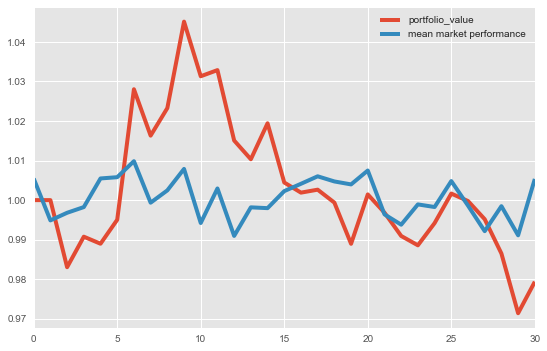

In [77]:
# show one run vs average market performance
df = pd.DataFrame(env_test.infos)
df.portfolio_value.plot()
df.returns.plot(label='mean market performance')
plt.legend()

Testing for 1 episodes ...
Episode 1: reward: 0.001, steps: 30
APV (Accumulated portfolio value): 	 1.02
SR (Sharpe ratio):                 	 588.99
MDD (max drawdown):                	-3.40%

Testing for 1 episodes ...
Episode 1: reward: 0.000, steps: 30
APV (Accumulated portfolio value): 	 1.01
SR (Sharpe ratio):                 	 626.92
MDD (max drawdown):                	-0.22%

Testing for 1 episodes ...
Episode 1: reward: 0.001, steps: 30
APV (Accumulated portfolio value): 	 1.04
SR (Sharpe ratio):                 	 273.98
MDD (max drawdown):                	-2.92%

Testing for 1 episodes ...
Episode 1: reward: -0.002, steps: 30
APV (Accumulated portfolio value): 	 0.95
SR (Sharpe ratio):                 	 332.76
MDD (max drawdown):                	-6.32%

Testing for 1 episodes ...
Episode 1: reward: -0.000, steps: 30
APV (Accumulated portfolio value): 	 1.00
SR (Sharpe ratio):                 	 1234.20
MDD (max drawdown):                	-1.79%

Testing for 1 episodes ...
Episo

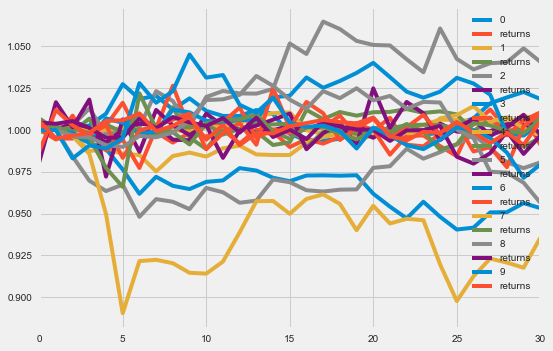

In [69]:
def sharpe(returns, freq=30, rfr=0):
    """Given a set of returns, calculates naive (rfr=0) sharpe (eq 28) """
    return (np.sqrt(freq) * np.mean(returns-rfr)) / np.std(returns - rfr)


def MDD(returns):
    """Max drawdown."""
    peak = returns.max()
    i = returns.argmax()
    trough = returns[returns.argmax():].min()
    return (trough-peak)/trough 

for i in range(10):
    agent.test(env_test, nb_episodes=1, visualize=False)
    df = pd.DataFrame(env_test.infos)
    sharpe(df.portfolio_value)
    print('APV (Accumulated portfolio value): \t{: 2.2f}'.format(df.portfolio_value.iloc[-1]))
    print('SR (Sharpe ratio):                 \t{: 2.2f}'.format( sharpe(df.portfolio_value)))
    print('MDD (max drawdown):                \t{: 2.2%}'.format( MDD(df.portfolio_value)))
    print('')
    df.portfolio_value.plot(label=str(i))
plt.legend()

# Visualise

In [ ]:
# history
df_hist = pd.DataFrame(history.history)
df_hist
df_hist['episodes'] = df_hist.index

g = sns.jointplot(x="episodes", y="episode_reward", data=df_hist, kind="reg", size=10)
plt.show()

# g = sns.jointplot(x="episodes", y="rewards", data=history, kind="reg")

In [ ]:
env_test.plot()

# dummy metrics

In [ ]:
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split


X_flat = X_train.reshape((len(X_train),-1))
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_flat, y_train, test_size=0.2, random_state=0)

def test_env(env, model, memory):
    obs = env.reset()
    state = memory.get_recent_state(obs)
    for t in range(env.days):
        x_batch = np.array([state])
        x_flat = x_batch.reshape((len(x_batch),-1))
        x_flat[np.isnan(x_flat)]=0
        y_pred = model.predict(x_flat)
        action = y_pred.argmax(1)
        obs, rew, done, info = env.step(action[0])
        state = memory.get_recent_state(obs)
    
    df_test = env.sim.to_df()
    end = df_test.iloc[-1]
    gain = end.bod_nav - end.mkt_nav    
    return gain

dummy_scores = []
for strategy in ['most_frequent', 'uniform', 'prior', 'stratified']:
    memory = Memory(window_length=window_length)
    clf = DummyClassifier(strategy=strategy)
    clf.fit(X_train, y_train)
    gain = test_env(env_test, clf, memory)
    df=env_test.sim.to_df()
    print('{:20.20s}: {: 3.2%} /day NAV gain above market'.format(strategy, (df.mkt_nav-df.bod_nav).mean()))
    
    plot_env(env_test, title=strategy)  

for strategy in ['mean', 'median']:
    memory = Memory(window_length=window_length)
    clf=DummyRegressor(strategy=strategy)
    clf.fit(X_train, y_train)
    gain = test_env(env_test, clf, memory)
    df=env_test.sim.to_df()
    print('{:20.20s}: {: 3.2%} /day NAV gain above market'.format(strategy, (df.mkt_nav-df.bod_nav).mean()))
    
    plot_env(env_test, title=strategy)  

In [ ]:
plot_env(env_test)